In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import ricker, gaussian, hanning

sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("coolwarm")
# sns.plotting_context(font_scale=0.5)

%matplotlib inline


import os
from functools import partial

In [2]:
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch import nn
from sklearn.preprocessing import MinMaxScaler

import tsensor

from models.data_utils import plot_sensors, plot_sensors_cwt
from models.dmd import MultiHankel, DMD, build_delay_embeddings, build_mrhankel

In [3]:
def set_gpu_devices(set_cpu=True):
    if torch.cuda.is_available():
        if torch.cuda.device_count()>1:
            device = "gpu:1"
        else:
            device = "gpu:0"
    else:
        device = "cpu"
    if set_cpu:
        device = "cpu"
    return device

In [4]:
device = set_gpu_devices(set_cpu=True)
device

'cpu'

In [5]:
from IPython.display import display, Audio, IFrame
from PIL.Image import fromarray, Image
from IPython import get_ipython
def numpy_to_png(a):
    assert 2 <= len(a.shape) <= 3, "Can't display {}-dimensional array of shape {}"\
        .format(len(a.shape), a.shape)
    return fromarray(np.array(np.clip(a, 0, 1) * 255, dtype='uint8'))._repr_png_()

get_ipython().display_formatter.formatters['image/png'].for_type(np.ndarray, numpy_to_png);
get_ipython().display_formatter.formatters['text/plain'].for_type(np.ndarray, lambda *x: "");

In [6]:
train = pd.read_csv("../data/train.csv")

In [7]:
train

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
...,...,...
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270


# Get a random time series segment:

Let's start by picking out a random time series and look at correlation between the sensor readings.

In [8]:
random_file = train.iloc[np.random.choice(train.index)]
data = {random_file.segment_id: 
        pd.read_csv(f"../data/train/{str(random_file.segment_id)}.csv")}
data_seg = data[random_file.segment_id].fillna(0.0)

print(data_seg.dtypes)
print(data_seg.shape)
data_seg.describe()
tensor_data = torch.tensor(data_seg.values)

sensor_1     float64
sensor_2     float64
sensor_3     float64
sensor_4     float64
sensor_5     float64
sensor_6     float64
sensor_7     float64
sensor_8     float64
sensor_9     float64
sensor_10    float64
dtype: object
(60001, 10)


In [9]:
#GOOD EXAMPLES: \
"""
segment_id          1120674393
time_to_eruption      13361950

segment_id          645145248
time_to_eruption     20639171

"""
random_file

segment_id          777298307
time_to_eruption     13738023
Name: 1295, dtype: int64

In [10]:
minmax = MinMaxScaler()
columns = data_seg.columns
data_seg = pd.DataFrame.from_records(minmax.fit_transform(data_seg.values))
data_seg.columns = columns
print(random_file)

segment_id          777298307
time_to_eruption     13738023
Name: 1295, dtype: int64


# Correlation Heat Maps:

Plotting a few correlation heat maps to the randomly chosen time series.
This is a simple starting point to begin gaining some understanding about the data eventhough it doesn't give a full picture of the data.
Understanding relationships between all the time series segments in the training data and develop features for the model might be a good way to proceed after developing a baseline end to end run.

## Dot product correlation: 

- This is a quick plot that captures how the sensors reinforce or cancel eachother.
- It was generated by the multiplying corresponding values between pair of sensors and summing the results.
- These sums are normalized by the total magnitude of the matrix.
- Higher the value greater the chance that the sensors are measuring the same event.
- Some of the files have missing sensor data. These missing values have been set to 0.

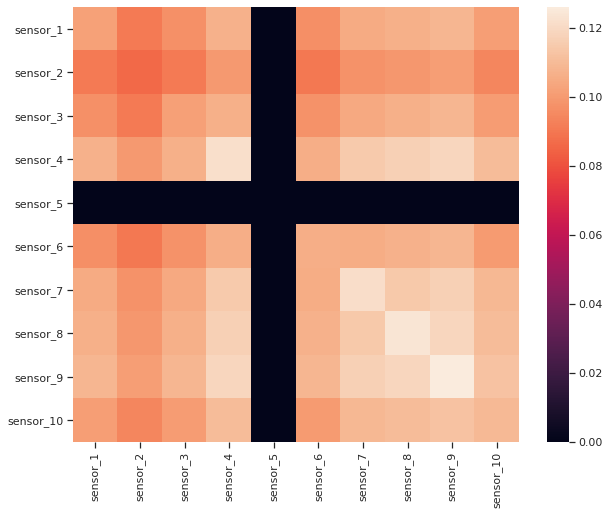

In [11]:
plt.figure(figsize=(10,8))
dot_product_correlation = np.dot(data_seg.values.T, data_seg.values)/(np.linalg.norm(data_seg.values)**2)
plot_df = pd.DataFrame.from_records(dot_product_correlation)
plot_df.columns = data_seg.columns
plot_df.index = data_seg.columns
sns.heatmap(plot_df)
plt.show()

# Singular Value Decomposition (SVD)

- Singular value decomposition projects the data matrix into a low dimensional linear space by expressing it as an   approximation of the product of 3 matrices.
- U is matrix where the rows are linearly independent of eachother, V is a matrix where the columns are linearly independent of eachother. S matrix scales the product according the eigenvalues that corresponding the eigenvectors in U and V.
- In this case SVD of the data matrix produces a V matrix with 10 rows and 10 columns for each pairwise product of the sensors. 
- The heatmap of the transposed V matrix shows which element values in the columns of V are significant in making them independent of eachother.

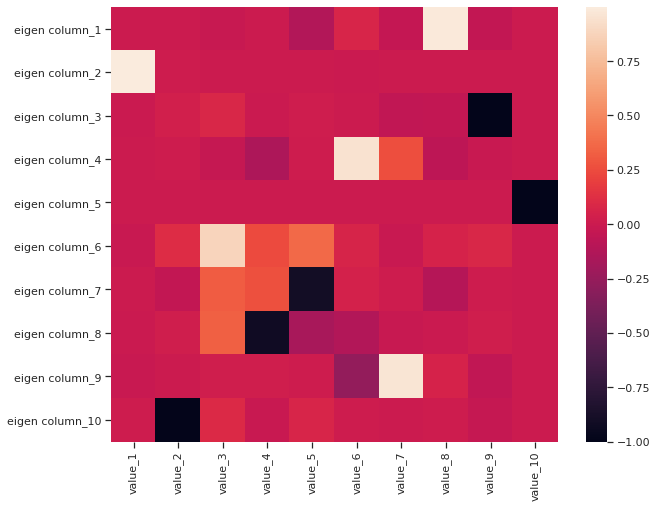

In [12]:
U,S,V = torch.svd(tensor_data)
V = V.T

plt.figure(figsize=(10,8))
plot_df = pd.DataFrame.from_records(V.T.numpy())
plot_df.columns = [col.replace("sensor_", "value_" ) for col in data_seg.columns]
plot_df.index = [col.replace("sensor_", "eigen column_" ) for col in data_seg.columns]
sns.heatmap(plot_df)
plt.show()

# Grammian Angular Field:

- This a method to convert a one dimensional time series into an image that captures the temporal correlation between each sensor.
- This is nifty preprocessing setup for summarizing a time series for use by a machine learning model. 
- Two methods are available: Summation and difference and the image size is a hyperparameter which can be set by tuning.
- Pyts is a great library where a lot of these functions have been implemented.

/home/gpk/anaconda3/envs/ingv/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


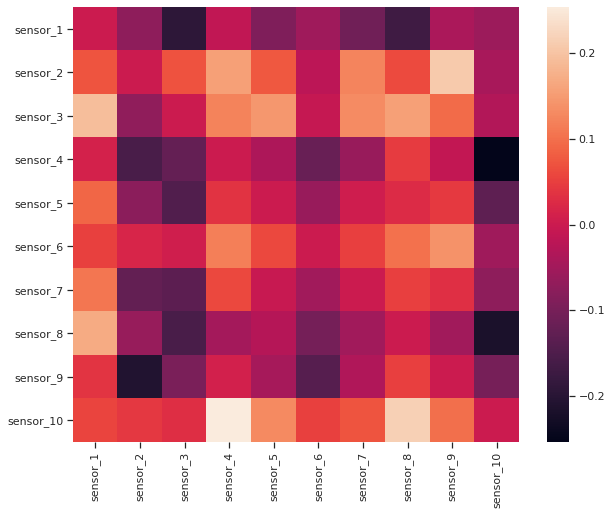

In [13]:
import pyts
from pyts.image import GramianAngularField

transformer = GramianAngularField(method="difference", image_size=10)

GM = transformer.transform(data_seg.values.T)
GM = GM.sum(axis=0)

plt.figure(figsize=(10,8))
plot_df = pd.DataFrame.from_dict(GM/np.linalg.norm(GM))
plot_df.columns = data_seg.columns
plot_df.index = data_seg.columns
sns.heatmap(plot_df)
plt.show()

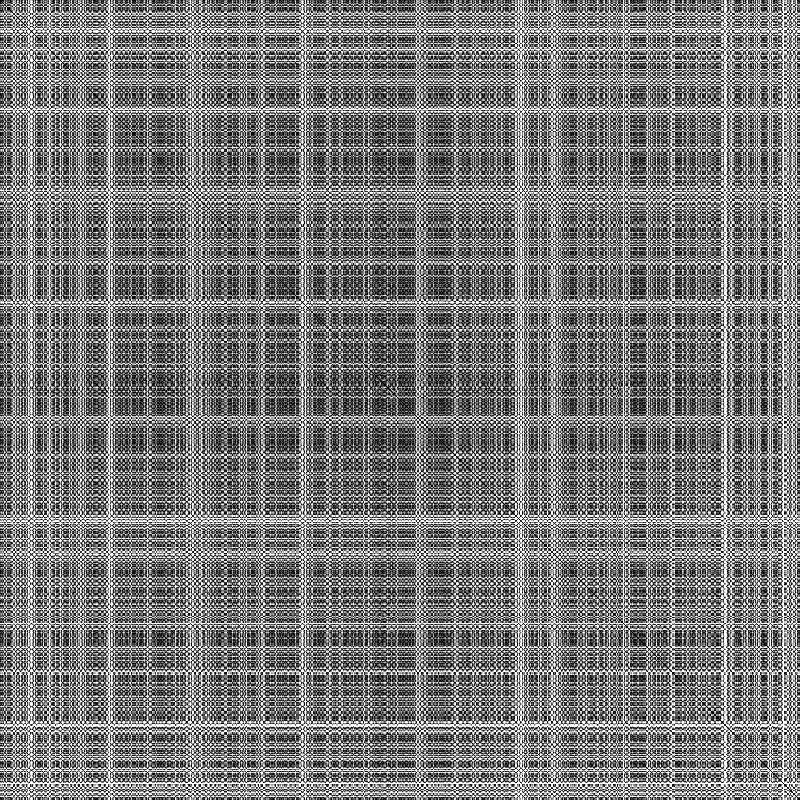

In [14]:
transformer = GramianAngularField(method="difference", image_size=800)
GM = transformer.transform(data_seg.values.T)
GM = GM.sum(axis=0)
500*(np.abs(GM)/np.linalg.norm(GM))

# Continuous Wavelet Transform:

- A wavelets are special functions that might be utilized in place of a simple window function. 
- They are parameterized by scale which sets the window size.
- A wavelet is better than a simple sliding window (square wavelet) because it overlaps with the sensor signal in way
that captures the relevant time and frequency content optimally.
- The choice of wavelet is data and problem dependent.
- A good starting choice is a gaussian.
- Mexican hat wavelet is another common choice of seismological data.
- A Scaleogram plots continuous wavelet transforms in a way that captures when a band of frequencies occurs in time.
- This is useful when compared to and FFT where all the time localization content in a signal is lost.


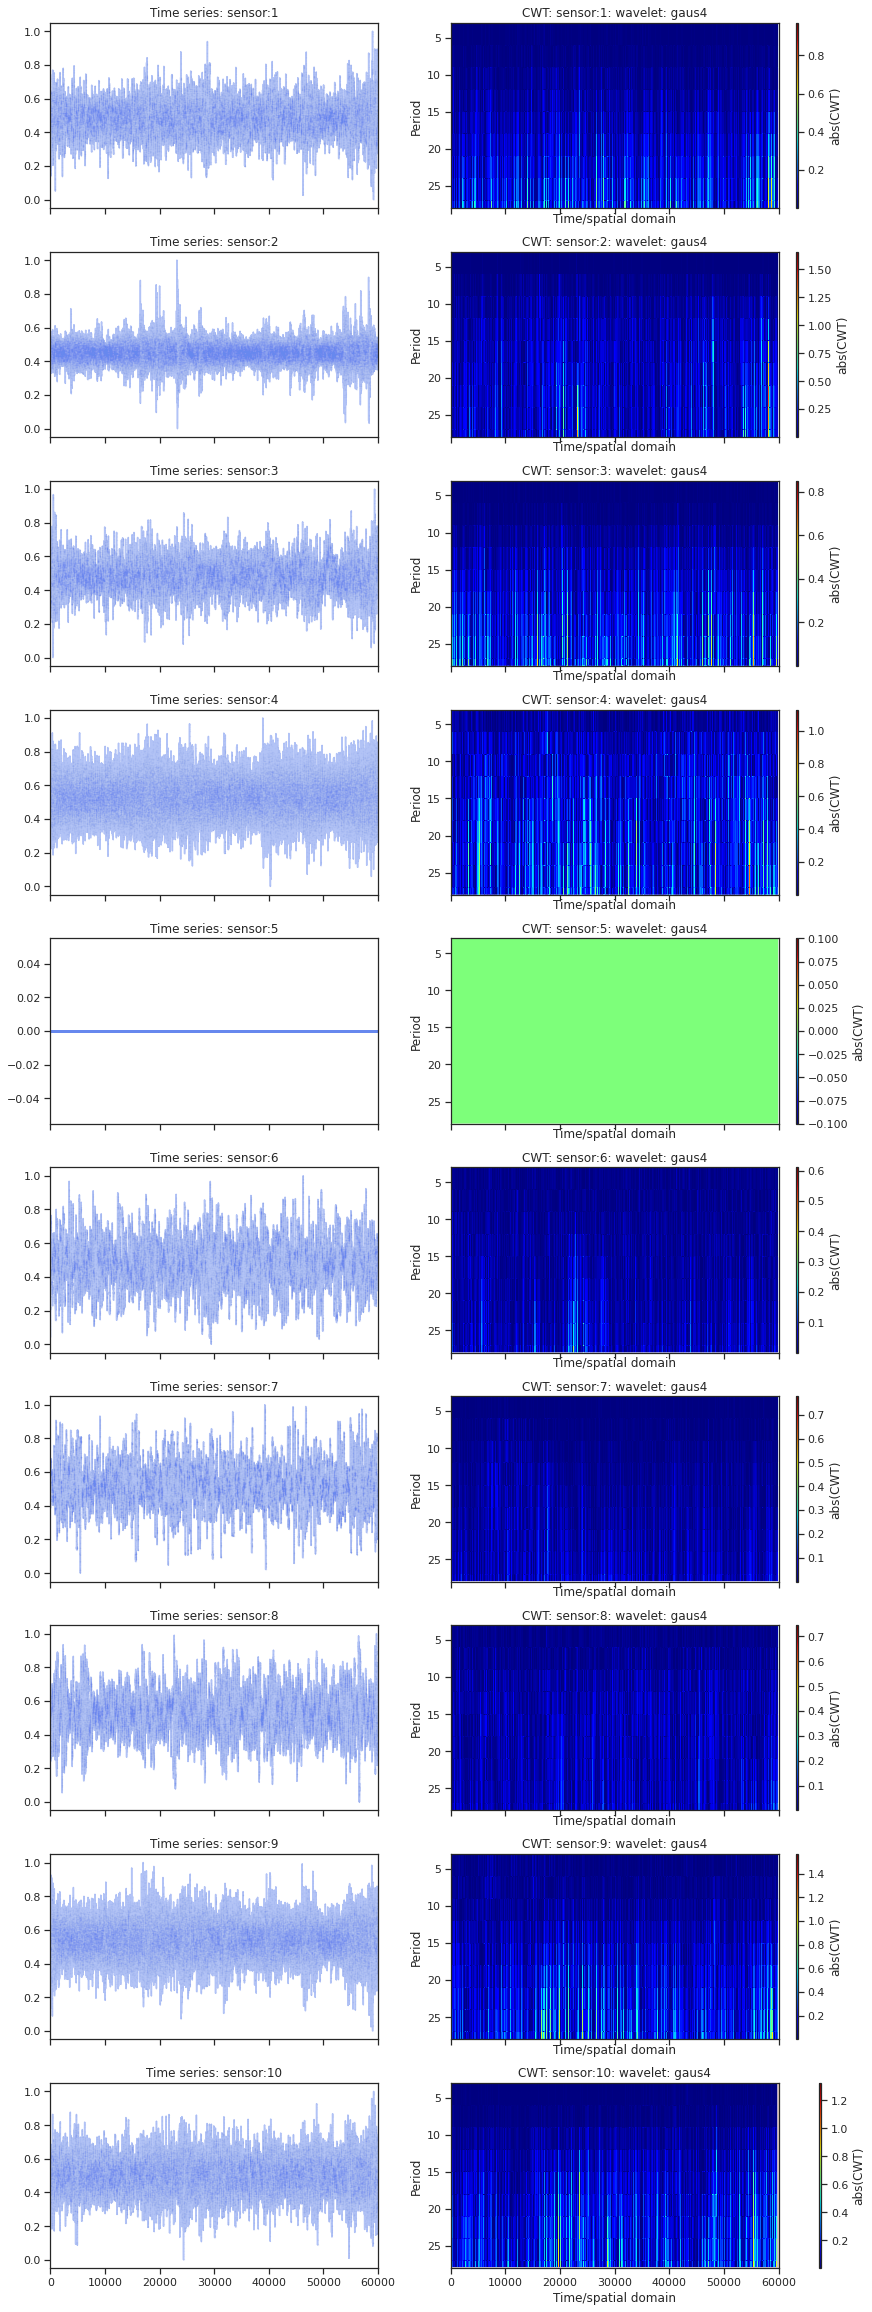

In [15]:
plot_sensors_cwt(data_seg, wavelet='gaus4', n_periods=10)

# Dynamic Mode Decomposition:

### What is DMD?

Dynamic Mode Decomposition or DMD is a method to extract dynamic information in unstructured data like audio and video by decomposing it into spatial and temporal modes.

DMD uses Singular Value Decomposition as a step in the process. However DMD provides a spatial decomposition of modes along with how they evolve over time. SVD only provides a spatial decomposition based on energy content.

The math behind DMD is linked to a theoretical framework that defines DMD as a best fit linear system to a non-linear dynamical system such that it advances measurements of the system forward in time similar to a Markov chain. The key idea is that an infinite dimensional linear approximation of non-linear dynamics allows any measurements of a non-linear system to be approximated by a linear system.

DMD is data driven and does not assume any knowledge of the underlying mechanism or process. Instead it relies on a large number of measurements of the state of the system. If you have enough sensors measuring a system and if the assumptions about a system are consistent with reality, DMD allows for discovering patterns in the data.

This video provides a great overview of DMD:
https://www.youtube.com/watch?v=sQvrK8AGCAo


### Delay Embeddings:

One of the assumptions of DMD is that our data captures the state of the system really well. This is not possible in practice. Even in the ideal case where we have a large number of measurements there could a problems with extracting some eigenvalues which capture phase information because the input data matrix does not have sufficient rank (too tall and skinny). The solution is to "fatten up" the input data by stacking delayed (or shifted) measurements into a larger matrix. This allows for phase information to be captured.

In [16]:
# Parameters for wavelet case:
EMBEDDING_DIM = 50
WINDOW_SIZE = 100
NUM_LAYERS = 4
DELAY_SIZE = 100
OVERLAP = 1
N_SCALES_MIN = 2
WAVELET=gaussian


# Parameters for no wavelet case:
# EMBEDDING_DIM = 250
# WINDOW_SIZE = 1000
# NUM_LAYERS = 5
# DELAY_SIZE = 100
# OVERLAP = 1
# N_SCALES_MIN = 2
# WAVELET = None


Input time series:


findfont: Font family ['Consolas'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


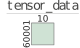

In [17]:
print("Input time series:")
with tsensor.explain():
    tensor_data

Splitting input time series into two overlapping segments with overlap = 1 time unit:


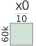

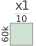

In [18]:
x0 = tensor_data[:-OVERLAP,:]
x1 = tensor_data[OVERLAP:,:]

print(f"Splitting input time series into two overlapping segments with overlap = {OVERLAP} time unit:")

with tsensor.explain():
    x0
    x1

In [19]:
hankel = MultiHankel(embedding_dim=EMBEDDING_DIM, 
                     window_size=WINDOW_SIZE, 
                     num_layers=NUM_LAYERS, 
                     delay_size=DELAY_SIZE,
                     wavelet=WAVELET,
                     n_scales_min=2)

In [20]:
h0 = hankel(x0)
h1 = hankel(x1)

In [37]:
print("Each each multiresolution layer is parametrized by:\
       \n(window size, number of windows, number of wavelet scales)\n")

print("For each layer in the multiresolution layer stack the window size is halved") 
print("and the number of windows is doubled.\n")
hankel_stack_shapes = list()
for stack_idx, stack in enumerate(hankel.layer_stack):
    print(f"Stack {stack_idx} input parameters: {stack}")
    hankel_stack_shapes.append(np.array([WINDOW_SIZE, EMBEDDING_DIM*stack[1]]))
    print(f"hankel layer shape: {WINDOW_SIZE, EMBEDDING_DIM*stack[1]}\n")

print(f"Final output shape for time series data: {WINDOW_SIZE, np.sum(hankel_stack_shapes, axis=0)[1]}")

Each each multiresolution layer is parametrized by:       
(window size, number of windows, number of wavelet scales)

For each layer in the multiresolution layer stack the window size is halved
and the number of windows is doubled.

Stack 0 input parameters: (100, 1, 2)
hankel layer shape: (100, 50)

Stack 1 input parameters: (50, 2, 4)
hankel layer shape: (100, 100)

Stack 2 input parameters: (25, 4, 8)
hankel layer shape: (100, 200)

Stack 3 input parameters: (12, 8, 16)
hankel layer shape: (100, 400)

Final output shape for time series data: (100, 750)


For 10 sensors in a csv file:


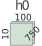

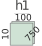

Appending all the sensor dimensions:


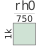

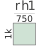

In [22]:
print(f"For {x0.shape[1]} sensors in a csv file:")
with tsensor.explain():
    h0
    h1
    
print("Appending all the sensor dimensions:")
rh0 = h0.squeeze()
rh0 = rh0.reshape(rh0.size(0) * WINDOW_SIZE, rh0.size(2))
rh1 = h1.squeeze()
rh1 = rh1.reshape(rh1.size(0) * WINDOW_SIZE, rh1.size(2))

with tsensor.explain():
    rh0
    rh1

## Step 1: Compute SVD of input data matrix:

$X = U\tilde{\Sigma}\tilde{V^{*}}$

Step 1: SVD of hankel stack corresponding to x0: 


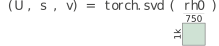

In [23]:
print("Step 1: SVD of hankel stack corresponding to x0: ")
with tsensor.explain():
    (U , s , v) =  torch.svd (rh0)

U, s, v =  torch.svd (rh0)

with tsensor.explain():
    U
    
with tsensor.explain():
    s

with tsensor.explain():
    v

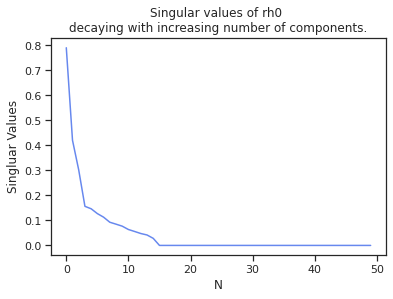

In [24]:
plt.title("Singular values of rh0 \ndecaying with increasing number of components.")
plt.plot((s/s.norm())[:50])
plt.xlabel("N")
plt.ylabel("Singluar Values")
plt.show()

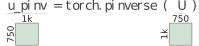

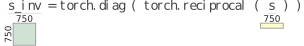

In [25]:
with tsensor.explain():
    u_pinv = torch.pinverse (U)
    
with tsensor.explain():
    s_inv = torch.diag ( torch.reciprocal (s) )

## Step 2: Calculate approximate linear dynamical operator $\tilde{A}$: 

Projecting A into the eigenmodes in $U$ reduces it to $\tilde{A}$:

$\tilde{A} = \tilde{U^{*}}A\tilde{U} = \tilde{U^{*}}X'\tilde{V}\tilde{\Sigma^{-1}}$

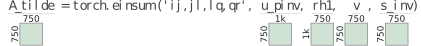

In [26]:
with tsensor.explain():
    A_tilde = torch.einsum ('ij,jl,lq,qr', u_pinv, rh1, v, s_inv)

## Step 3: Compute spectral decomposition of $\tilde{A}$:

$\tilde{A}W = W\Lambda$

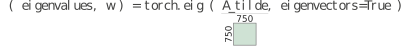

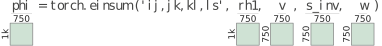

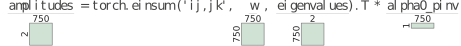

In [27]:
print("\n")
with tsensor.explain():
    ( eigenvalues, w ) = torch.eig ( A_tilde, eigenvectors=True )

print("\n")
with tsensor.explain():
    phi = torch.einsum ('ij,jk,kl,ls', rh1, v, s_inv, w)
    
alpha0 = torch.einsum('ij,j', s_inv, v[1, :]).T
alpha0_pinv = torch.pinverse(alpha0.reshape(-1, 1))

print("\n")
with tsensor.explain():
    amplitudes = torch.einsum ('ij,jk', w, eigenvalues).T * alpha0_pinv

# Visualizing DMD modes:

- Pair plot of the dynamic modes have interesting correlations between them because DMD modes are not necessarily orthogonal modes.
- The delay coordinates matrix and the DMD modes matrix show interesting structure.
- Delay coordinates capture how the DMD modes change in time but while computing the 

DMD Modes


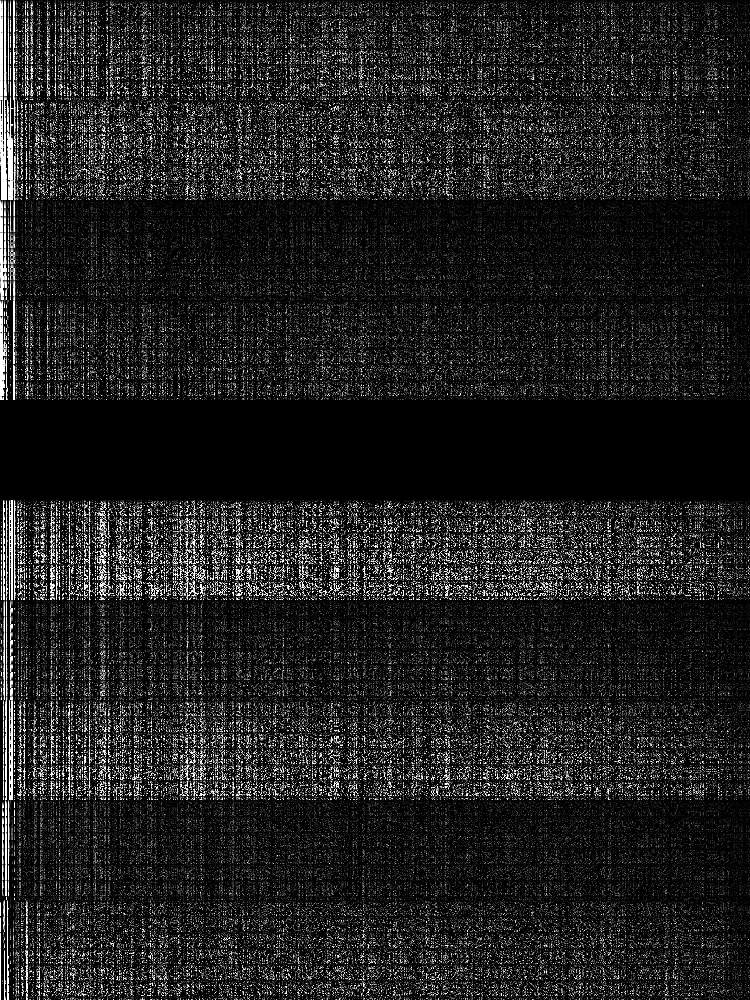

In [28]:
print("DMD Modes")
100*phi.numpy()

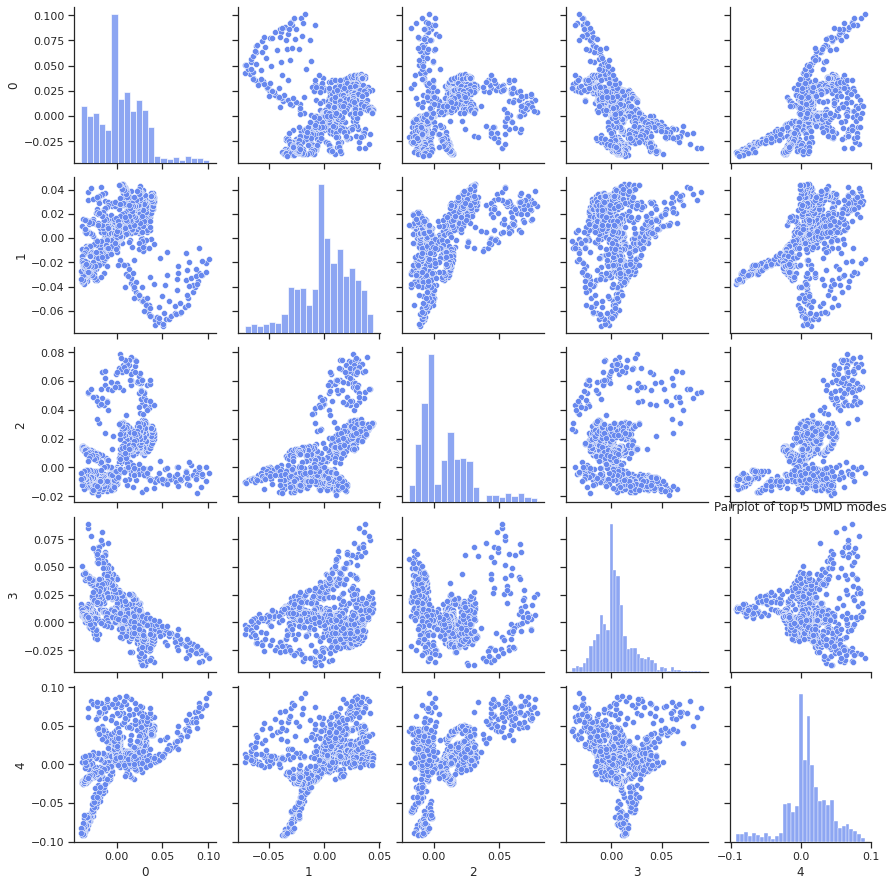

In [29]:
sns.pairplot(pd.DataFrame(phi[:,:5].numpy()))
plt.title("Pairplot of top 5 DMD modes")
plt.show()

Delay Coordinates


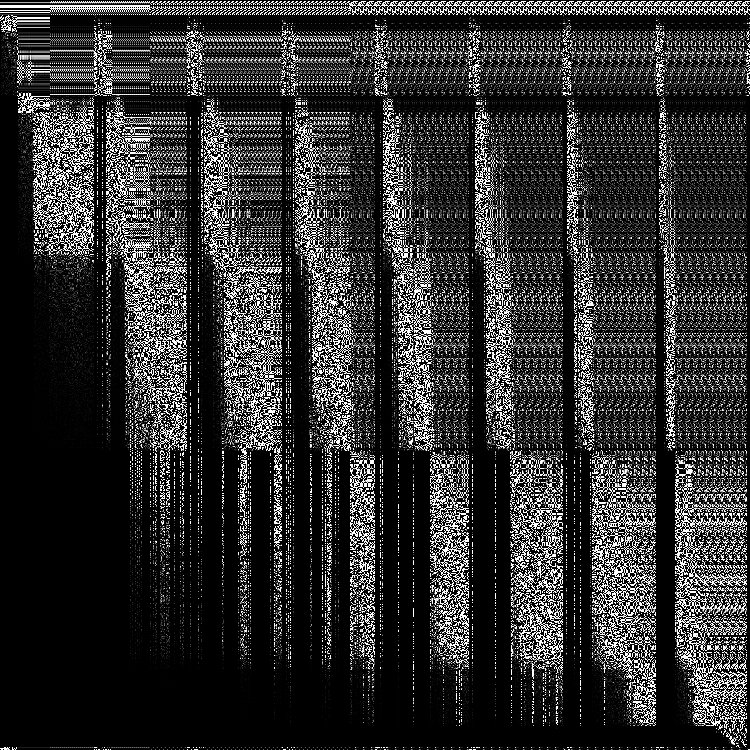

In [30]:
print("Delay Coordinates")
100*v.T.numpy()

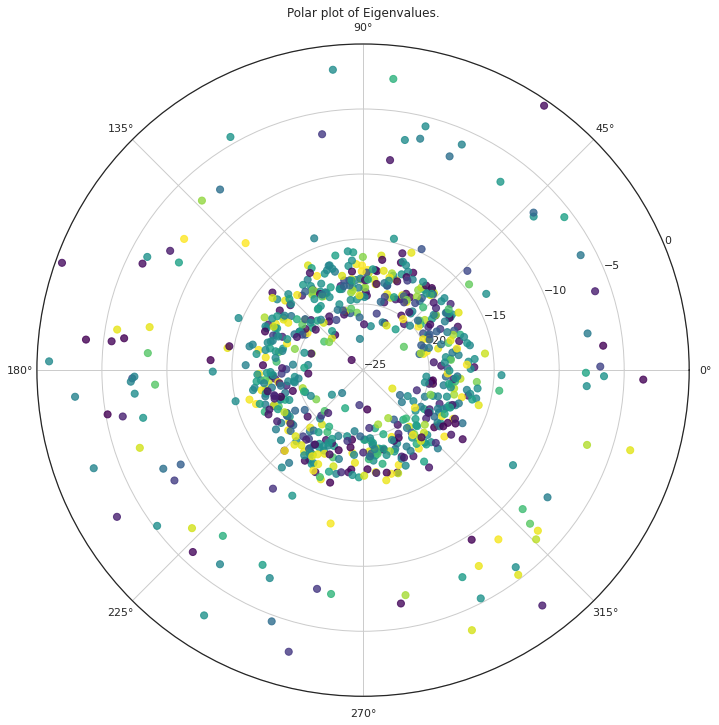

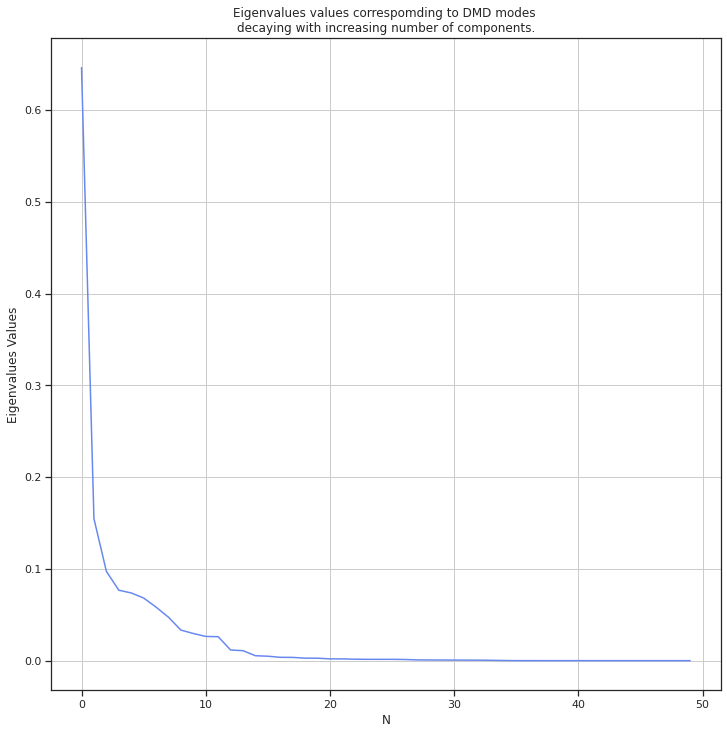

In [31]:
amp = torch.view_as_complex(amplitudes.T)
mag = (sum(amp.real**2 + amp.imag**2))**0.5
amp = amp/mag
d = torch.log(amp)
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='polar')
ax.scatter(np.rad2deg(d.imag), 
           d.real, 
           c=np.rad2deg(d.imag), 
           cmap='viridis', alpha=0.8, s=50,)
ax.set_title("Polar plot of Eigenvalues.")
plt.show()

lam = torch.sqrt(sum(amplitudes**2))
fig = plt.figure(figsize=(12,12))
plt.plot(sorted((lam/lam.norm()).numpy()[:50], reverse=True))
plt.title("Eigenvalues values correspomding to DMD modes \ndecaying with increasing number of components.")
plt.xlabel("N")
plt.ylabel("Eigenvalues Values")
plt.grid("on")
plt.show()
plt.show()

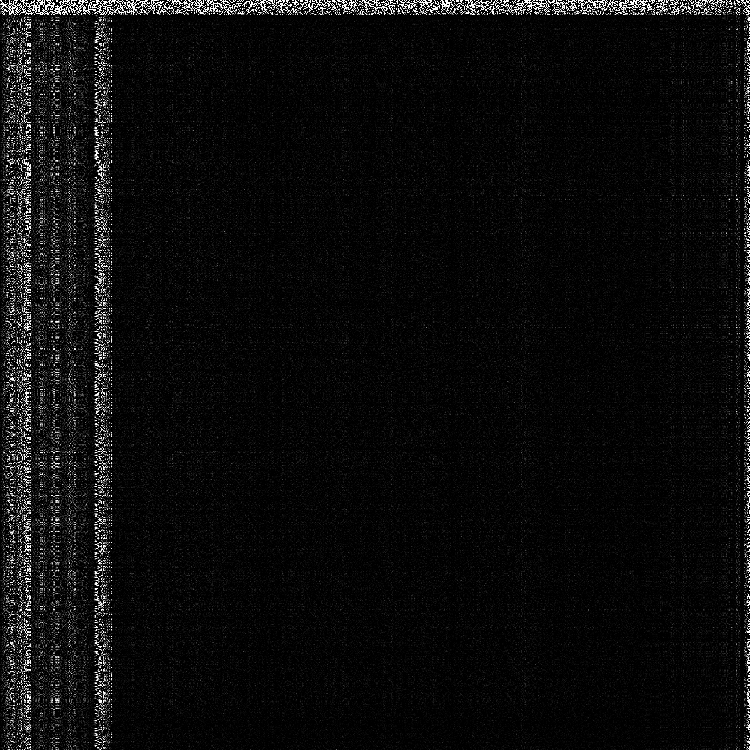

In [38]:
100*A_tilde.numpy()

In [34]:
dmd = DMD()
phi, amplitudes, delay_coords = dmd(rh0, rh1)

In [35]:
print(f"Sanity check is {np.allclose(dmd.A_tilde.numpy(), A_tilde)}")

Sanity check is True



References: 
- dmdbook.com
- J. N. Kutz, S. L. Brunton, B. W. Brunton, and J. L. Proctor. Dynamic Mode Decomposition: Data-Driven Modeling of Complex Systems. SIAM, 2016.
- https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/dynamic-mode-decomposition-of-numerical-and-experimental-data/AA4C763B525515AD4521A6CC5E10DBD4
- http://dmdbook.com/